### Main Model

In [ ]:
# To replicate, specify the paths according to your user folder structure

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, set_seed
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

train = pd.read_csv("C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Datasets/train.csv")
dev   = pd.read_csv("C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Datasets/dev.csv")
test  = pd.read_csv("C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Datasets/test.csv")

label_map = {label: i for i, label in enumerate(train['label'].unique())}
train['label'] = train['label'].map(label_map)
dev['label']   = dev['label'].map(label_map)
test['label']  = test['label'].map(label_map)

train_ds = Dataset.from_pandas(train)
dev_ds   = Dataset.from_pandas(dev)
test_ds  = Dataset.from_pandas(test)

# ==============================
# Tokenizer + Model
# ==============================
model_name = "castorini/afriberta_base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

def tokenize_fn(batch):
    return tokenizer(batch['tweet'], truncation=True, padding="max_length", max_length=64)

train_ds = train_ds.map(tokenize_fn, batched=True)
dev_ds   = dev_ds.map(tokenize_fn, batched=True)
test_ds  = test_ds.map(tokenize_fn, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_map))

set_seed(42)

# ==============================
# Metrics + Confusion Matrix
# ==============================
history_conf_matrices = []  

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    cm = confusion_matrix(labels, preds, labels=list(label_map.values()))
    history_conf_matrices.append(cm)

    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro")
    }

# ==============================
# Training Setup
# ==============================
training_args = TrainingArguments(
    output_dir="C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Results/afriberta_exp1",
    learning_rate=2e-5,
    per_device_train_batch_size=16, 
    gradient_accumulation_steps=1,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",           
    load_best_model_at_end=True,      
    metric_for_best_model="macro_f1", 
    greater_is_better=True,
    save_total_limit=1,             
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=dev_ds,
    compute_metrics=compute_metrics,
)

print("Setup complete. Run trainer.train() to start training.")


C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\transformers\convert_slow_tokenizer.py:558: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/13841 [00:00<?, ? examples/s]

Map:   0%|          | 0/1730 [00:00<?, ? examples/s]

Map:   0%|          | 0/1731 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Setup complete. Run trainer.train() to start training.


C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [5]:
trainer.train()

C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.583700,0.446365,0.822543,0.824253
2,0.413700,0.494610,0.802312,0.801938


C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\transformers\configuration_utils.py:384: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\transformers\configuration_utils.py:384: UserWarning: Some non-default generation parameters are set in the model config

KeyboardInterrupt: 

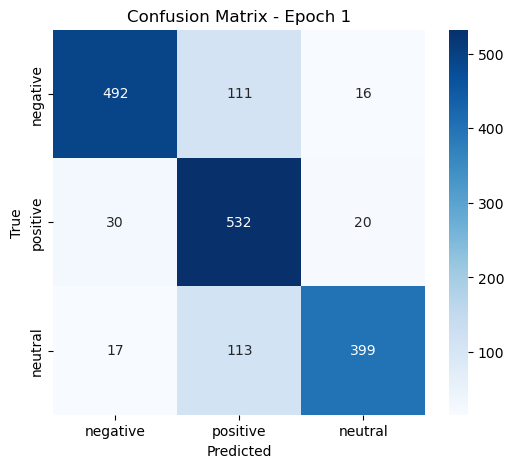

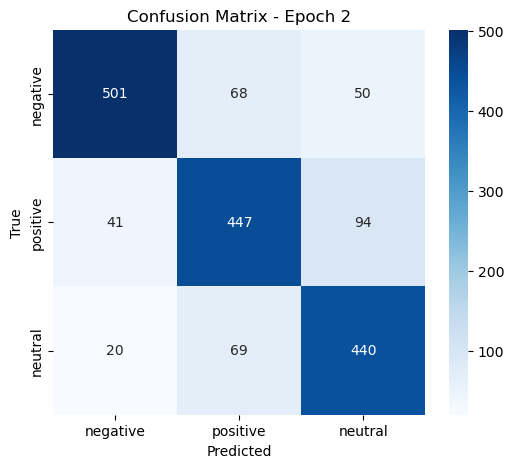

In [6]:
# Confusion Matrix

labels = list(label_map.keys())

for epoch, cm in enumerate(history_conf_matrices, 1):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Epoch {epoch}")
    plt.show()


### Resume running from the best checkpoint (Increased Weight Decay)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, set_seed
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

train = pd.read_csv("C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Datasets/train.csv")
dev   = pd.read_csv("C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Datasets/dev.csv")
test  = pd.read_csv("C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Datasets/test.csv")

label_map = {label: i for i, label in enumerate(train['label'].unique())}
train['label'] = train['label'].map(label_map)
dev['label']   = dev['label'].map(label_map)
test['label']  = test['label'].map(label_map)

train_ds = Dataset.from_pandas(train)
dev_ds   = Dataset.from_pandas(dev)
test_ds  = Dataset.from_pandas(test)

# ==============================
#  Tokenizer
# ==============================
model_name = "castorini/afriberta_base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

def tokenize_fn(batch):
    return tokenizer(batch['tweet'], truncation=True, padding="max_length", max_length=64)

train_ds = train_ds.map(tokenize_fn, batched=True)
dev_ds   = dev_ds.map(tokenize_fn, batched=True)
test_ds  = test_ds.map(tokenize_fn, batched=True)

# ==============================
#  Load Model Checkpoint
# ==============================
resume_from = "C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Results/afriberta_exp1/checkpoint-866"

try:
    model = AutoModelForSequenceClassification.from_pretrained(resume_from, num_labels=len(label_map))
    print(f"Loaded checkpoint from {resume_from}")
except:
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_map))
    print("No checkpoint found, starting fresh.")

set_seed(42)

# ==============================
# 4. Metrics + Confusion Matrix
# ==============================
history_conf_matrices = []

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    cm = confusion_matrix(labels, preds, labels=list(label_map.values()))
    history_conf_matrices.append(cm)

    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro")
    }

# ==============================
#  Training Setup
# ==============================
training_args = TrainingArguments(
    output_dir="C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Results/afriberta_exp2",
    learning_rate=2e-5,       
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    num_train_epochs=3,        
    weight_decay=0.02,    # changed from 0.01 to 0.02     
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    save_total_limit=1,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=dev_ds,
    compute_metrics=compute_metrics,
)

print("Setup complete. Run trainer.train() to start training.")



C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\transformers\convert_slow_tokenizer.py:558: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/13841 [00:00<?, ? examples/s]

Map:   0%|          | 0/1730 [00:00<?, ? examples/s]

Map:   0%|          | 0/1731 [00:00<?, ? examples/s]

Loaded checkpoint from C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Results/afriberta_exp1/checkpoint-866
Setup complete. Run trainer.train() to start training.


C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [8]:
trainer.train()

C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.299400,0.569075,0.819075,0.819260
2,0.312300,0.582961,0.802312,0.800962
3,0.210300,0.694872,0.813873,0.813343


C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\transformers\configuration_utils.py:384: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\transformers\configuration_utils.py:384: UserWarning: Some non-default generation parameters are set in the model config

TrainOutput(global_step=2598, training_loss=0.2739812544073115, metrics={'train_runtime': 22184.7808, 'train_samples_per_second': 1.872, 'train_steps_per_second': 0.117, 'total_flos': 913597592429952.0, 'train_loss': 0.2739812544073115, 'epoch': 3.0})

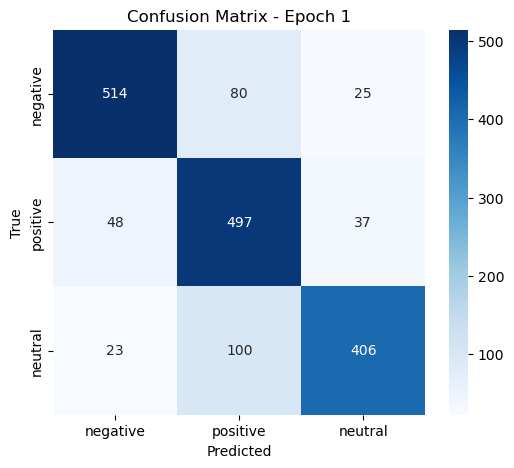

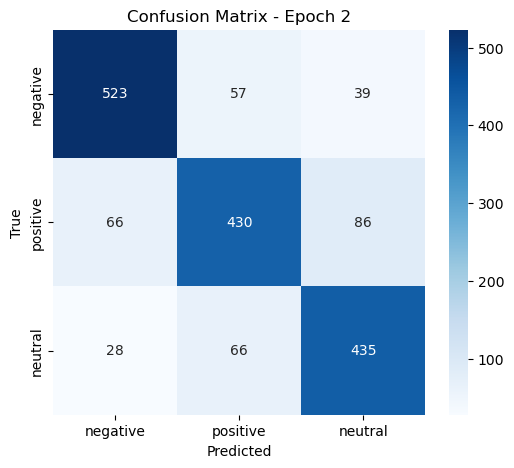

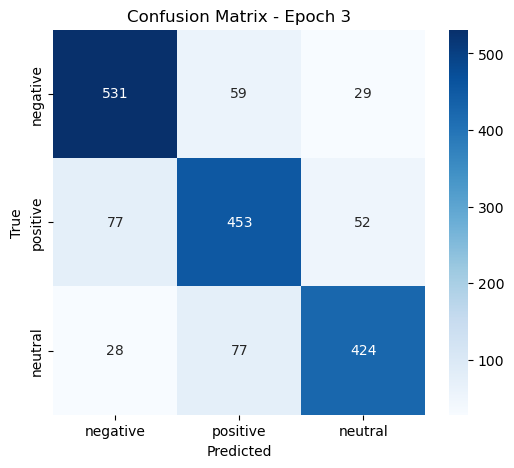

In [9]:
# Confusion Matrix

labels = list(label_map.keys())

for epoch, cm in enumerate(history_conf_matrices, 1):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Epoch {epoch}")
    plt.show()


### Resume running from the best checkpoint with Early Stopping (Increased Weight Decay and No. of Epochs)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    set_seed,
    EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

train = pd.read_csv("C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Datasets/train.csv")
dev   = pd.read_csv("C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Datasets/dev.csv")
test  = pd.read_csv("C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Datasets/test.csv")

label_map = {label: i for i, label in enumerate(train['label'].unique())}
train['label'] = train['label'].map(label_map)
dev['label']   = dev['label'].map(label_map)
test['label']  = test['label'].map(label_map)

train_ds = Dataset.from_pandas(train)
dev_ds   = Dataset.from_pandas(dev)
test_ds  = Dataset.from_pandas(test)

# ==============================
#  Tokenizer
# ==============================
model_name = "castorini/afriberta_base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

def tokenize_fn(batch):
    return tokenizer(batch['tweet'], truncation=True, padding="max_length", max_length=64)

train_ds = train_ds.map(tokenize_fn, batched=True)
dev_ds   = dev_ds.map(tokenize_fn, batched=True)
test_ds  = test_ds.map(tokenize_fn, batched=True)

# ==============================
#  Load Model Checkpoint
# ==============================
resume_from = "C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Results/afriberta_exp1/checkpoint-866"

try:
    model = AutoModelForSequenceClassification.from_pretrained(resume_from, num_labels=len(label_map))
    print(f"Loaded checkpoint from {resume_from}")
except:
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_map))
    print("No checkpoint found, starting fresh.")

set_seed(42)

# ==============================
#  Metrics + Confusion Matrix
# ==============================
history_conf_matrices = []

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    cm = confusion_matrix(labels, preds, labels=list(label_map.values()))
    history_conf_matrices.append(cm)

    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro")
    }

# ==============================
#  Training Setup
# ==============================
training_args = TrainingArguments(
    output_dir="C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Results/afriberta_exp3",
    learning_rate=2e-5,       
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    num_train_epochs=6,             # changed from 3 to 6
    weight_decay=0.03,               # changed from 0.02 to 0.03
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    save_total_limit=1,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=dev_ds,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] 
)

print("Setup complete. Run trainer.train() to start training.")



C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\transformers\convert_slow_tokenizer.py:558: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/13841 [00:00<?, ? examples/s]

Map:   0%|          | 0/1730 [00:00<?, ? examples/s]

Map:   0%|          | 0/1731 [00:00<?, ? examples/s]

Loaded checkpoint from C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Results/afriberta_exp1/checkpoint-866
Setup complete. Run trainer.train() to start training.


C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
trainer.train()

C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.303400,0.574165,0.820231,0.820547
2,0.328400,0.536047,0.804046,0.803559
3,0.227300,0.641685,0.811561,0.810641
4,0.160700,0.887109,0.809827,0.808867


C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\transformers\configuration_utils.py:384: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\transformers\configuration_utils.py:384: UserWarning: Some non-default generation parameters are set in the model config

TrainOutput(global_step=3464, training_loss=0.2549778936090976, metrics={'train_runtime': 19574.7424, 'train_samples_per_second': 4.243, 'train_steps_per_second': 0.265, 'total_flos': 1218130123239936.0, 'train_loss': 0.2549778936090976, 'epoch': 4.0})

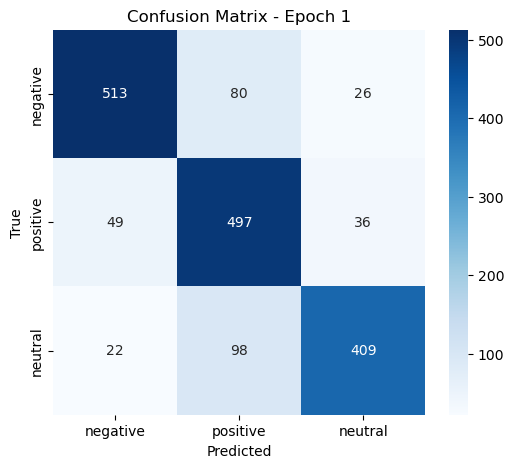

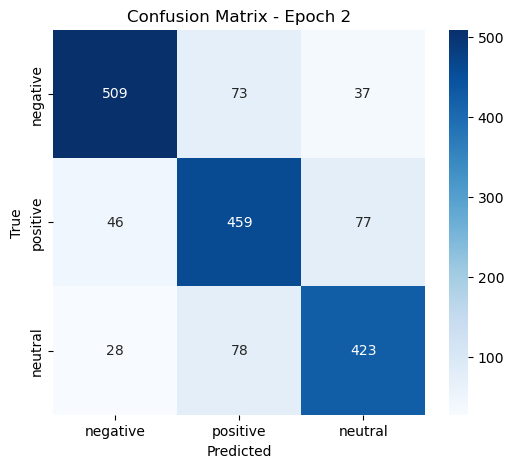

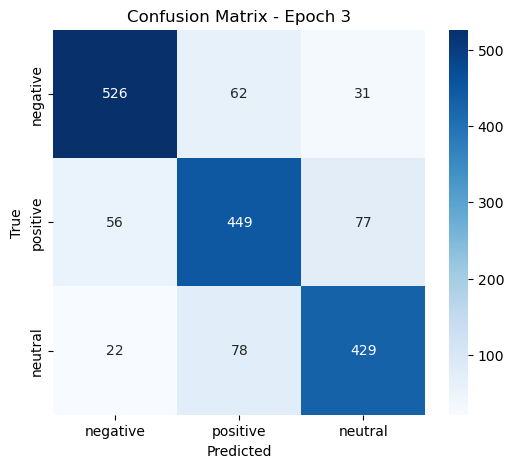

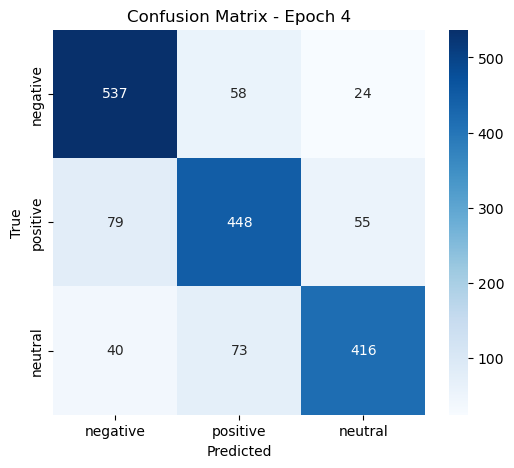

[array([[513,  80,  26],
       [ 49, 497,  36],
       [ 22,  98, 409]], dtype=int64), array([[509,  73,  37],
       [ 46, 459,  77],
       [ 28,  78, 423]], dtype=int64), array([[526,  62,  31],
       [ 56, 449,  77],
       [ 22,  78, 429]], dtype=int64), array([[537,  58,  24],
       [ 79, 448,  55],
       [ 40,  73, 416]], dtype=int64)]


In [14]:
# Confusion Matrix

labels = list(label_map.keys())

for epoch, cm in enumerate(history_conf_matrices, 1):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Epoch {epoch}")
    plt.show()

print(history_conf_matrices)

### Resume running from the checkpoint with Early Stopping (lower Learning Rate and Warmup Ratio)

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    set_seed,
    EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


train = pd.read_csv("C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Datasets/train.csv")
dev   = pd.read_csv("C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Datasets/dev.csv")
test  = pd.read_csv("C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Datasets/test.csv")

label_map = {label: i for i, label in enumerate(train['label'].unique())}
train['label'] = train['label'].map(label_map)
dev['label']   = dev['label'].map(label_map)
test['label']  = test['label'].map(label_map)

train_ds = Dataset.from_pandas(train)
dev_ds   = Dataset.from_pandas(dev)
test_ds  = Dataset.from_pandas(test)

# ==============================
#  Tokenizer
# ==============================
model_name = "castorini/afriberta_base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

def tokenize_fn(batch):
    return tokenizer(batch['tweet'], truncation=True, padding="max_length", max_length=64)

train_ds = train_ds.map(tokenize_fn, batched=True)
dev_ds   = dev_ds.map(tokenize_fn, batched=True)
test_ds  = test_ds.map(tokenize_fn, batched=True)

# ==============================
#  Load Model Checkpoint
# ==============================
resume_from = "C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Results/afriberta_exp1/checkpoint-866"

try:
    model = AutoModelForSequenceClassification.from_pretrained(resume_from, num_labels=len(label_map))
    print(f"Loaded checkpoint from {resume_from}")
except:
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_map))
    print("No checkpoint found, starting fresh.")

set_seed(42)

# ==============================
#  Metrics + Confusion Matrix
# ==============================
history_conf_matrices = []

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    cm = confusion_matrix(labels, preds, labels=list(label_map.values()))
    history_conf_matrices.append(cm)

    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro")
    }

# ==============================
#  Training Setup
# ==============================
training_args = TrainingArguments(
    output_dir="C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Results/afriberta_exp4_lr1e5_wu01",
    learning_rate=1e-5,             # lowered from 2e-5
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    num_train_epochs=6,            
    weight_decay=0.03,             
    warmup_ratio=0.1,             
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    save_total_limit=1,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=dev_ds,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  
)

print("Setup complete. Run trainer.train() to start training.")



C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\transformers\convert_slow_tokenizer.py:558: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/13841 [00:00<?, ? examples/s]

Map:   0%|          | 0/1730 [00:00<?, ? examples/s]

Map:   0%|          | 0/1731 [00:00<?, ? examples/s]

Loaded checkpoint from C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/Results/afriberta_exp1/checkpoint-866
Setup complete. Run trainer.train() to start training.


C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
trainer.train()

C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.289500,0.573581,0.817341,0.817973
2,0.351800,0.528579,0.806936,0.806382
3,0.270100,0.587919,0.817919,0.817176
4,0.210000,0.708654,0.815029,0.814133


C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\transformers\configuration_utils.py:384: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\transformers\configuration_utils.py:384: UserWarning: Some non-default generation parameters are set in the model config

TrainOutput(global_step=3464, training_loss=0.2803533391093547, metrics={'train_runtime': 22251.6159, 'train_samples_per_second': 3.732, 'train_steps_per_second': 0.234, 'total_flos': 1218130123239936.0, 'train_loss': 0.2803533391093547, 'epoch': 4.0})

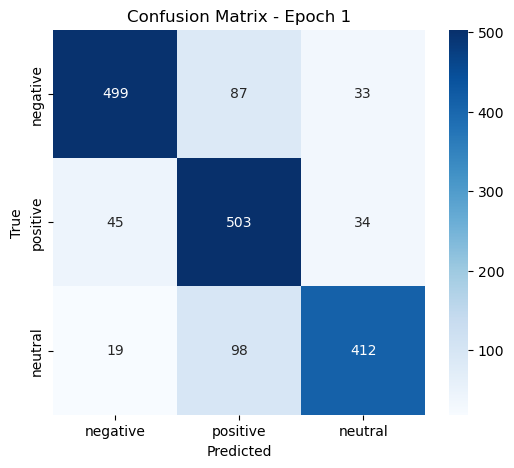

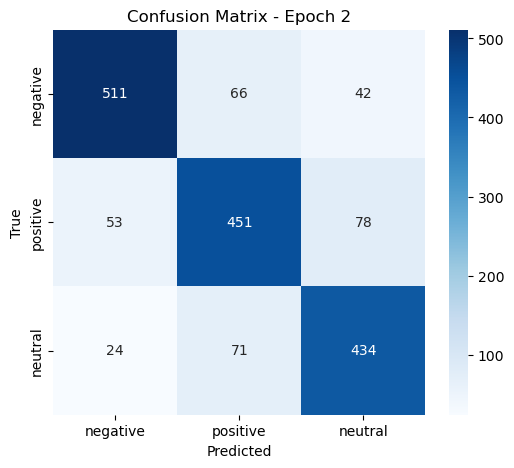

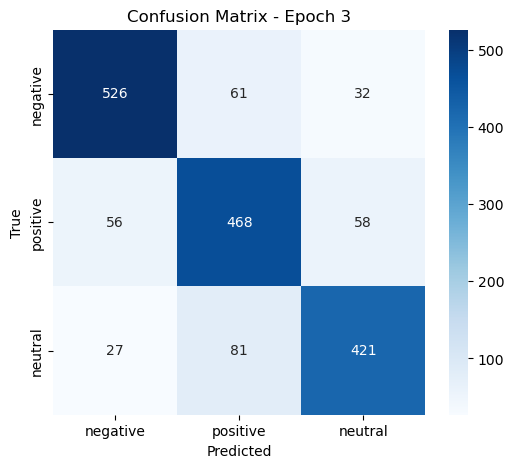

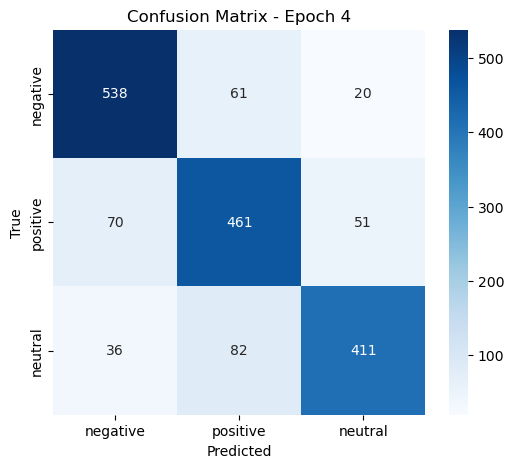

[array([[499,  87,  33],
       [ 45, 503,  34],
       [ 19,  98, 412]], dtype=int64), array([[511,  66,  42],
       [ 53, 451,  78],
       [ 24,  71, 434]], dtype=int64), array([[526,  61,  32],
       [ 56, 468,  58],
       [ 27,  81, 421]], dtype=int64), array([[538,  61,  20],
       [ 70, 461,  51],
       [ 36,  82, 411]], dtype=int64)]


In [17]:
# Confusion Matrix

labels = list(label_map.keys())

for epoch, cm in enumerate(history_conf_matrices, 1):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Epoch {epoch}")
    plt.show()

print(history_conf_matrices)

### Saving the model and tokenizer

In [18]:
save_dir = "C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/model/sentiment_model"

model.config.label2id = label_map
model.config.id2label = {v: k for k, v in label_map.items()}

trainer.save_model(save_dir)        
tokenizer.save_pretrained(save_dir) 

C:\Users\T-Plug\anaconda3\envs\social_media_mining_env\Lib\site-packages\transformers\configuration_utils.py:384: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(


('C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/model/sentiment_model\\tokenizer_config.json',
 'C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/model/sentiment_model\\special_tokens_map.json',
 'C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/model/sentiment_model\\sentencepiece.bpe.model',
 'C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/model/sentiment_model\\added_tokens.json',
 'C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/model/sentiment_model\\tokenizer.json')

In [19]:
# Printing the label order (to be specified in model_predict.py)

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("C:/Users/T-Plug/Desktop/University/Level 300/2nd Sem/316 Social Media Mining/End_Of_Sem_Project/model/sentiment_model")
print(model.config.id2label)

{0: 'negative', 1: 'positive', 2: 'neutral'}
